In [34]:
#Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers as ml
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator as Imgen

from PIL import Image

### **Loading the Data**

In [35]:
train_ds = Imgen(rescale=1./255).flow_from_directory("../input/face-mask-12k-images-dataset/Face Mask Dataset/Train",
                                                    target_size=(128,128),
                                                    seed = 123,
                                                    batch_size= 32
                                                    )

val_ds = Imgen(rescale=1./255).flow_from_directory("../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation",
                                                    target_size=(128,128),
                                                    seed = 123,
                                                    batch_size= 32
                                                    )
test_ds = Imgen(rescale=1./255).flow_from_directory("../input/face-mask-12k-images-dataset/Face Mask Dataset/Test",
                                                    target_size=(128,128),
                                                    seed = 123,
                                                    batch_size= 32
                                                    )

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [36]:
X, y = next(train_ds)
print(X.shape,y.shape)

(32, 128, 128, 3) (32, 2)


**Visualizing**

In [37]:
pred_class = list(train_ds.class_indices.keys())
pred_class

['WithMask', 'WithoutMask']

In [38]:
dist = train_ds.classes
len(dist)

10000

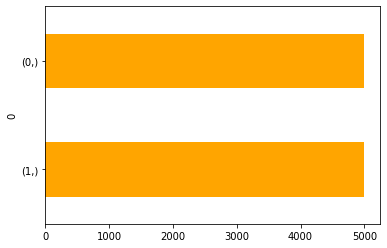

In [39]:
un_dist = pd.DataFrame(dist).value_counts()
un_dist.plot(kind='barh',color='orange');

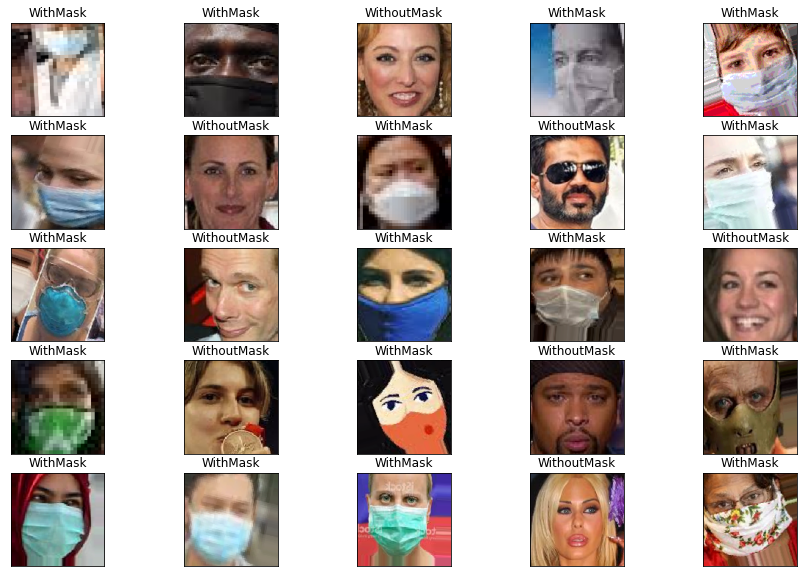

In [40]:
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.title(pred_class[np.argmax(y[i])])


## **Model**

In [41]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception

In [42]:
base_model = Xception(include_top=False,
                              weights='imagenet',
                              input_shape=(128,128,3))
base_model.trainable = False

In [43]:
model = keras.models.Sequential([
    base_model,
    ml.GlobalAveragePooling2D(),
    
    ml.Dense(64,activation='relu'),
    ml.Dropout(0.5),
    
     ml.Dense(32,activation='relu'),
    ml.Dropout(0.5),
    
    ml.Dense(2,activation='relu')
])

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

In [45]:
model.compile(optimizer='sgd',loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [46]:
#callbacks
my_calls = [keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
            keras.callbacks.ModelCheckpoint(monitor='val_accuracy',save_best_only=True,mode='max',filepath="./")]

**Train**

In [47]:
hist = model.fit(train_ds,epochs=15,validation_data=val_ds,callbacks=my_calls)

Epoch 1/15
313/313 [==============================] - 36s 102ms/step - loss: 0.6141 - accuracy: 0.6766 - val_loss: 0.3811 - val_accuracy: 0.9887
Epoch 2/15
313/313 [==============================] - 30s 94ms/step - loss: 0.4298 - accuracy: 0.9504 - val_loss: 0.3641 - val_accuracy: 0.9912
Epoch 3/15
313/313 [==============================] - 29s 94ms/step - loss: 0.4034 - accuracy: 0.9675 - val_loss: 0.3601 - val_accuracy: 0.9925
Epoch 4/15
313/313 [==============================] - 29s 94ms/step - loss: 0.3938 - accuracy: 0.9739 - val_loss: 0.3602 - val_accuracy: 0.9912
Epoch 5/15
313/313 [==============================] - 29s 93ms/step - loss: 0.3820 - accuracy: 0.9826 - val_loss: 0.3595 - val_accuracy: 0.9925
Epoch 6/15
313/313 [==============================] - 29s 94ms/step - loss: 0.3769 - accuracy: 0.9847 - val_loss: 0.3581 - val_accuracy: 0.9937
Epoch 7/15
313/313 [==============================] - 29s 92ms/step - loss: 0.3733 - accuracy: 0.9856 - val_loss: 0.3578 - val_accuracy

**Test**

In [48]:
model.evaluate(test_ds)

31/31 [==============================] - 3s 89ms/step - loss: 0.3652 - accuracy: 0.9889


[0.36520567536354065, 0.9889112710952759]

**Graphs**

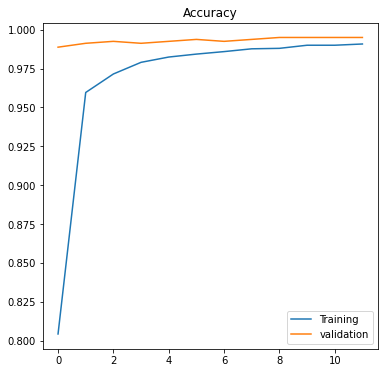

In [57]:
plt.figure(figsize=(6,6))

plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()
plt.show()

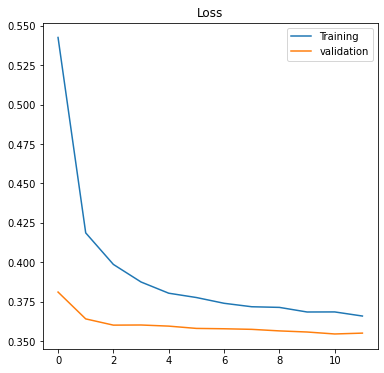

In [58]:
plt.figure(figsize=(6,6))

plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()


**Test Data**

In [59]:
test_imgs,test_labels = next(test_ds)

In [60]:
pred_test = model.predict(test_imgs)
pred_test = [np.argmax(i) for i in pred_test]

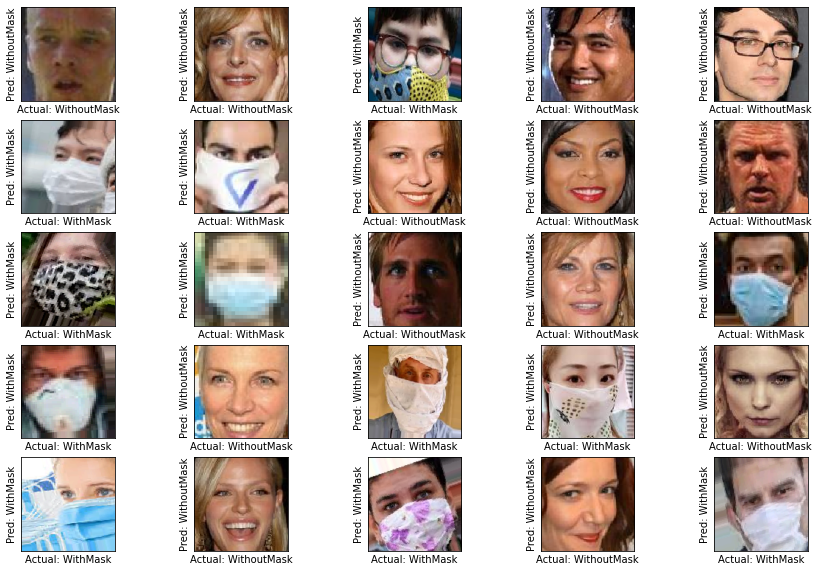

In [61]:
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_imgs[i])
    plt.xlabel("Actual: {}".format(pred_class[np.argmax(test_labels[i])]))
    plt.ylabel("Pred: {}".format(pred_class[pred_test[i]]))
